<a href="https://colab.research.google.com/github/infected4098/Oil-compete/blob/main/Oil_compete_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파일 임포트


In [ ]:
pip install -U Ray

In [127]:
#딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary as summary_

#하이퍼파라미터 튜닝
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


#전처리, 점수 측정
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#컴퓨터 리소스 할당 관련 
import os
from tqdm.auto import tqdm 

#기초 툴, 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#기타
import warnings
warnings.filterwarnings("ignore")

#통계 패키지. 다중공선성 체크
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA



In [128]:
#드라이브 소싱
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#document 위치: /Users/infected4098/Desktop/오일상태 분류

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [129]:
train_1 = pd.read_csv("/content/gdrive/MyDrive/오일상태 분류/train.csv")

move_train = train_1.copy()

test = pd.read_csv("/content/gdrive/MyDrive/오일상태 분류/test.csv")


print(train_1.shape, test.shape)

#데이터가 14095개. feature 는 54개. 

(14095, 54) (6041, 19)


In [130]:
train_col = train_1.columns

#test_col = test.columns

test_col = [ 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN']

# 이상치 체크


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

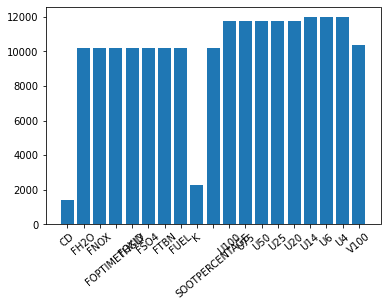

In [131]:
#무명 feature 1, 2
anon = ["ANONYMOUS_1", "ANONYMOUS_2"]
na_value = train_1.apply(lambda x: x.isna().sum())


real_na = na_value[na_value>0]

plt.bar(real_na.index, real_na)
plt.xticks(rotation=40)

In [132]:
#카드뮴 함유량 정보는 결측치가 1394개 있음.
#FH20. FNOX, FOPTIMETHGLY, 

#결측치들 처리 방식에 대해 고민하기
for value in list(train_1["CD"].unique()):
  print(value, sum(train_1["CD"]==value))
#0이 거의 대부분의 데이터니까 .train["CD"]는 결측값 0으로 대체

0.0 12543
nan 0
1.0 138
2.0 16
4.0 1
18.0 1
3.0 2


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
14090    0.0
14091    0.0
14092    0.0
14093    0.0
14094    0.0
Name: CD, Length: 14095, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f8b88277690>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8b88272950>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8b88245610>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8b8826e390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8b8829fa50>],
 'means': []}

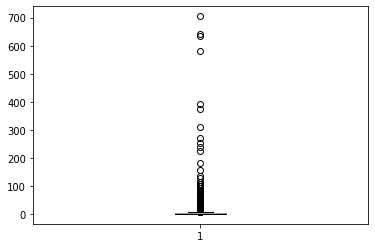

In [133]:
move_train["CD"] = move_train["CD"].fillna(0)
print(move_train["CD"])

#potassium 함유량. "K". 결측치 2292개 
K_nonna_train = train_1[train_1["K"].isna()==False]

plt.boxplot(K_nonna_train["K"])

In [134]:
K_nonna_train["K"].describe()

count    11796.000000
mean         3.611224
std         15.630404
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max        705.000000
Name: K, dtype: float64

In [135]:
K_median = K_nonna_train["K"].median()
#중위값으로 대체하자 


move_train["K"]=move_train["K"].fillna(K_median)


move_train["K"].isna().sum()

0

In [136]:
med_na_index = real_na.index[1:8]
for i in med_na_index:
  print(train_1[i].describe(), train_1[i].median(), train_1[i].skew())

count    3890.000000
mean       15.242159
std        17.591679
min         6.000000
25%        11.000000
50%        13.000000
75%        15.000000
max       320.000000
Name: FH2O, dtype: float64 13.0 12.364062325726515
count    3890.000000
mean        7.138303
std         1.860775
min         3.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        38.000000
Name: FNOX, dtype: float64 7.0 2.7896483732121005
count    3890.000000
mean        0.532905
std         0.621937
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        13.000000
Name: FOPTIMETHGLY, dtype: float64 0.0 3.6802441734442652
count    3890.000000
mean       12.495373
std         3.439535
min         4.000000
25%        10.000000
50%        12.000000
75%        14.750000
max        68.000000
Name: FOXID, dtype: float64 12.0 2.6158954295372467
count    3890.000000
mean       20.284319
std         3.234296
min        10.000000
25%        18.000000
50%        2

In [137]:
move_train["FH2O"] = move_train["FH2O"].fillna(train_1["FH2O"].median())
move_train["FOPTIMETHGLY"] = move_train["FOPTIMETHGLY"].fillna(0) #0이 median
move_train["FNOX"] = move_train["FNOX"].fillna(7) #7이 median
move_train["FOXID"] = move_train["FOXID"].fillna(12) #12이 median
move_train["FSO4"] = move_train["FSO4"].fillna(20) #20이 median
move_train["FUEL"] = move_train["FUEL"].fillna(0) #0이 median
move_train["FTBN"] = move_train["FTBN"].fillna(train_1["FTBN"].mean()) #skew 하지 않으니 mean 으로 대체 

In [138]:
for leftover_index in real_na[9:].index:
  if np.abs(train_1[leftover_index].skew())>2.0:
    #skewed. using median
    move_train[leftover_index]=move_train[leftover_index].fillna(train_1[leftover_index].median())

  else:
    #not skewed. using mean
    move_train[leftover_index]=move_train[leftover_index].fillna(train_1[leftover_index].mean())



In [139]:
for leftover_index in real_na.index:
  print(leftover_index, train_1[leftover_index].skew())


CD 53.085134085837545
FH2O 12.364062325726515
FNOX 2.7896483732121005
FOPTIMETHGLY 3.6802441734442652
FOXID 2.6158954295372467
FSO4 2.8015301110224584
FTBN 0.33652232468627147
FUEL 7.702714468957186
K 28.54532689833669
SOOTPERCENTAGE 3.1248690960146366
U100 10.60227309035654
U75 9.397804721596914
U50 17.096806745232513
U25 9.169211128868708
U20 8.95908749147654
U14 7.830824094820337
U6 15.45037688667643
U4 11.6221442436233
V100 0.8423555837867412


# 범주형 데이터 처리 및 연산량 너무 쓸모없이 많은 거 처리


In [140]:
real_train = move_train.copy()
real_train = real_train.drop(["ID"], axis=1)
#real_train.head()
#real_train.groupby(["COMPONENT_ARBITRARY"]).describe()
#이미 id로 index reset 함.

In [141]:

#label encoding 

le = LabelEncoder()
le.fit(real_train["COMPONENT_ARBITRARY"])
le_encoded = le.transform(real_train["COMPONENT_ARBITRARY"])
real_train["COMPONENT_ARBITRARY"] = le_encoded


In [142]:
#one-hot encoding


In [143]:
real_train

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,2,1486,2011,7,200,0,3,93,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,154.0,75,0
1,1,1350,2021,51,375,0,2,19,0,0,...,2.0,4.0,6.0,216.0,1454.0,0,13.57623,44.0,652,0
2,1,2415,2015,2,200,0,110,1,1,0,...,0.0,3.0,39.0,11261.0,41081.0,0,13.57623,72.6,412,1
3,2,7389,2010,2,200,0,8,3,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,133.3,7,0
4,2,3954,2015,4,200,0,1,157,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,2,1616,2014,8,200,0,2,201,1,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,135.4,16,0
14091,0,2784,2013,2,200,0,3,85,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,14.50000,117.5,1408,0
14092,2,1788,2008,9,550,0,6,0,1,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,54.0,1301,0
14093,1,2498,2009,19,550,0,2,4,0,0,...,7.0,8.0,100.0,1625.0,18890.0,0,13.57623,44.3,652,0


In [144]:
real_train["YEAR"].value_counts()

2008    1419
2014    1400
2013    1189
2015    1156
2011    1146
2012    1073
2009     949
2016     942
2017     896
2018     878
2010     866
2019     649
2021     477
2020     373
2022     354
2007     328
Name: YEAR, dtype: int64

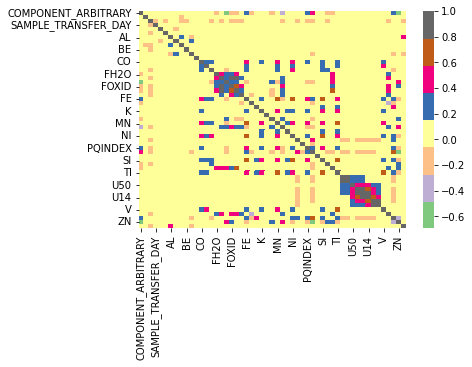

In [145]:
#is year important? 
sns.heatmap(real_train.corr(), cmap="Accent")

In [146]:
for i in real_train.columns:
  year_coef = np.corrcoef(real_train["YEAR"], real_train[i])[0, 1]
  if abs(year_coef)>0.1: 
    print("YEAR /", i, "간 corr: ", year_coef)

#year 의 설명력 낮아서 지워도 무방할 것 같습니다. 


YEAR / ANONYMOUS_1 간 corr:  0.10654556184441208
YEAR / YEAR 간 corr:  1.0
YEAR / ANONYMOUS_2 간 corr:  0.13819862552773787
YEAR / AG 간 corr:  -0.1291240066260261
YEAR / CU 간 corr:  -0.13759315060624594
YEAR / FNOX 간 corr:  -0.1341722186781992
YEAR / FOXID 간 corr:  -0.12408413469995706
YEAR / FTBN 간 corr:  -0.16380712281789836
YEAR / P 간 corr:  -0.14367534457659714
YEAR / S 간 corr:  -0.14108442314423023


# 데이터 간 관계 파악 (EDA seq2)


In [147]:
corr_df = real_train.corr()

#동일 코드를 대충 5번 해서 확인하기
for col in corr_df.columns[:20]:
  spec_corr = corr_df[col].apply(lambda x: np.abs(x))
  spec_corr = spec_corr.apply(lambda x: np.round(x, 3))
  spec_corr.sort_values(ascending=False, inplace=True)

  #print(spec_corr[spec_corr>0.5], spec_corr[spec_corr>0.5].index)
  if len(corr_df[col][spec_corr[spec_corr>0.5].index][1:])!=0:
    print(corr_df[col][spec_corr[spec_corr>0.5].index][1:], "\n")
  #print(spec_corr[1], spec_corr.index[1])
  


ZN             -0.542198
FOPTIMETHGLY   -0.516068
Name: COMPONENT_ARBITRARY, dtype: float64 

FE    0.536765
Name: CO, dtype: float64 

SOOTPERCENTAGE    0.514388
Name: FH2O, dtype: float64 

FOXID             0.806131
FSO4              0.792636
SOOTPERCENTAGE    0.557262
Name: FNOX, dtype: float64 

COMPONENT_ARBITRARY   -0.516068
Name: FOPTIMETHGLY, dtype: float64 

FNOX    0.806131
FSO4    0.763552
MO      0.541772
Name: FOXID, dtype: float64 

FNOX              0.792636
FOXID             0.763552
SOOTPERCENTAGE    0.678053
Name: FSO4, dtype: float64 



In [148]:
for col in corr_df.columns[20:40]:
  spec_corr = corr_df[col].apply(lambda x: np.abs(x))
  spec_corr = spec_corr.apply(lambda x: np.round(x, 3))
  spec_corr.sort_values(ascending=False, inplace=True)

  #print(spec_corr[spec_corr>0.5], spec_corr[spec_corr>0.5].index)
  if len(corr_df[col][spec_corr[spec_corr>0.5].index][1:])!=0:
    print(corr_df[col][spec_corr[spec_corr>0.5].index][1:], "\n")
  #print(spec_corr[1], spec_corr.index[1])

SI    0.649188
MN    0.622415
NI    0.583322
CO    0.536765
Name: FE, dtype: float64 

SI    0.561308
TI    0.506896
Name: K, dtype: float64 

FE    0.622415
TI    0.585042
SI    0.554424
NI    0.527618
Name: MN, dtype: float64 

FOXID    0.541772
Name: MO, dtype: float64 

SI    0.630178
FE    0.583322
MN    0.527618
Name: NI, dtype: float64 

ZN    -0.692957
V40    0.606647
Name: S, dtype: float64 

FE    0.649188
NI    0.630178
TI    0.605636
K     0.561308
MN    0.554424
Name: SI, dtype: float64 

FSO4    0.678053
FNOX    0.557262
FH2O    0.514388
Name: SOOTPERCENTAGE, dtype: float64 

V     0.677756
SI    0.605636
MN    0.585042
K     0.506896
Name: TI, dtype: float64 



In [149]:
for col in corr_df.columns[40:]:
  spec_corr = corr_df[col].apply(lambda x: np.abs(x))
  spec_corr = spec_corr.apply(lambda x: np.round(x, 3))
  spec_corr.sort_values(ascending=False, inplace=True)

  #print(spec_corr[spec_corr>0.5], spec_corr[spec_corr>0.5].index)
  if len(corr_df[col][spec_corr[spec_corr>0.5].index][1:])!=0:
    print(corr_df[col][spec_corr[spec_corr>0.5].index][1:], "\n")
  else:
    pass
  #print(spec_corr[1], spec_corr.index[1])

U75    0.875127
Name: U100, dtype: float64 

U100    0.875127
Name: U75, dtype: float64 

U25    0.528807
U20    0.510142
Name: U50, dtype: float64 

U20    0.907602
U14    0.754829
U50    0.528807
Name: U25, dtype: float64 

U25    0.907602
U14    0.847609
U50    0.510142
Name: U20, dtype: float64 

U20    0.847609
U25    0.754829
U6     0.661679
Name: U14, dtype: float64 

U4     0.823573
U14    0.661679
Name: U6, dtype: float64 

U6    0.823573
Name: U4, dtype: float64 

TI    0.677756
Name: V, dtype: float64 

S    0.606647
Name: V40, dtype: float64 

S                     -0.692957
COMPONENT_ARBITRARY   -0.542198
Name: ZN, dtype: float64 



In [150]:
real_train.groupby(["COMPONENT_ARBITRARY"])["AL"].describe()

#AL ,AG, CU, CR, FE, PB, NI, SN

#B, CA, MG, MO, NA, P, Zn

,count,mean,std,min,25%,50%,75%,max
COMPONENT_ARBITRARY,,,,,,,,
0,3890.0,10.285861,62.124561,0.0,1.0,2.0,4.0,1515.0
1,2316.0,18.402850,144.922980,0.0,1.0,2.0,5.0,4630.0
2,7050.0,12.999007,76.793985,0.0,1.0,2.0,4.0,2032.0
3,839.0,5.767580,38.764876,0.0,1.0,2.0,4.0,962.0


In [151]:
real_train.sort_values(by=["AL"], ascending=True)[:30]

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
14094,1,1902,2012,15,200,0,0,77,0,0,...,1163.0,2565.0,11296.0,181016.0,325823.0,0,13.57623,47.0,612,0
2632,1,1000,2014,6,200,0,0,3,0,0,...,3.0,11.0,112.0,1078.0,13235.0,0,13.57623,63.0,340,0
12466,0,1368,2010,7,200,0,0,136,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,14.80000,126.2,948,0
6005,0,1674,2008,2,550,0,0,2,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.70000,108.0,1309,0
2637,2,5153,2016,6,200,0,0,1,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,131.1,70,0
12461,2,9353,2010,3,200,0,0,0,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,151.6,53,0
6001,1,3499,2015,20,200,0,0,1,0,0,...,35.0,86.0,450.0,10841.0,26402.0,0,13.57623,43.9,620,0
2641,2,1655,2011,12,855,0,0,16,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,13.57623,139.2,13,0
6000,1,6990,2021,2,593,0,0,2,0,0,...,23.0,41.0,78.0,1277.0,3301.0,0,13.57623,68.5,132,0
2643,0,3093,2015,9,200,0,0,172,0,0,...,7.0,13.0,57.0,1753.0,12691.5,0,12.70000,97.7,1024,0


# PCA 를 통해 U, F 차원 축소


In [152]:
U_index = ["U100", "U75", "U50", "U25", "U20", "U14", "U6", "U4"]
U_components = real_train[U_index]

pca=PCA(n_components=2)
prince = pca.fit_transform(U_components)
U_principal = pd.DataFrame(prince, columns= ["U_small", "U_big"])
print(U_principal)

             U_small         U_big
0       -1136.824218    210.606607
1      -12278.131337  -1914.366364
2       28801.366587    258.420426
3       -1136.824218    210.606607
4       -1136.824218    210.606607
...              ...           ...
14090   -1136.824218    210.606607
14091   -1136.824218    210.606607
14092   -1136.824218    210.606607
14093    4697.693750   2306.244913
14094  352883.993152 -70184.450769

[14095 rows x 2 columns]


In [153]:
real_train = real_train.drop(U_index, axis=1)
real_train = pd.concat([real_train, U_principal], axis=1)
print(real_train.shape)

(14095, 47)


# 데이터 스케일링


In [162]:
all_X = real_train.drop(["Y_LABEL", "YEAR"], axis=1)
all_y = real_train["Y_LABEL"]
#all_X["YEAR"]=0

#print(real_train)


In [163]:
#component arbitrary 제외하고 전부 

for col in all_X.columns:
  if col not in [ "COMPONENT_ARBITRARY", "FTBN"]:
    scaler=StandardScaler()
    all_X[col] = scaler.fit_transform(all_X[[col]])
  elif col == "FTBN":
    scaler=RobustScaler()
    all_X[col] = scaler.fit_transform(all_X[[col]])

print(all_X.head())

   COMPONENT_ARBITRARY  ANONYMOUS_1  SAMPLE_TRANSFER_DAY  ANONYMOUS_2  \
0                    2    -0.393763            -0.051413    -0.340760   
1                    1    -0.426022             3.715319    -0.022576   
2                    1    -0.173409            -0.479451    -0.340760   
3                    2     1.006399            -0.479451    -0.340760   
4                    2     0.191634            -0.308236    -0.340760   

         AG        AL         B        BA        BE        CA  ...        SI  \
0 -0.150214 -0.111628  0.281646 -0.238453 -0.041491  1.141962  ...  2.006643   
1 -0.150214 -0.123127 -0.437686 -0.238453 -0.041491  1.087302  ... -0.179489   
2 -0.150214  1.118753 -0.612659  0.105735 -0.041491 -0.910846  ... -0.179489   
3 -0.150214 -0.054133 -0.593217 -0.238453 -0.041491  0.400333  ... -0.174370   
4 -0.150214 -0.134626  0.903771 -0.238453 -0.041491 -0.874406  ... -0.169250   

         SN  SOOTPERCENTAGE        TI        V  V100       V40        ZN  \
0  0

In [164]:
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=156, stratify=all_y)


print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(11276, 45) (2819, 45) (11276,) (2819,)


# Vanilla 를 위한 모델 준비

만일 위에서 변수의 개수 바꾸면 여기서는 batch size 만 조정해 주면 됨


In [165]:
#scaling 안 하고 작업해보는 것이 우선이 되면 좋을 것 같아요. 그거 해보고 안되면 scaling 해보고.. pseudo labelling 도 해보자.

#11월 22일 verison. scaling 이 꼭 필요할 것 같습니다. 
#basic paramerters. furthrer investigation needed.
CFG = {
    'EPOCHS': 20,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':64,
    'SEED':41
}

In [166]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_col].iloc[index]) #보수부분. student는 19개 정도의 column만 갖고 있음
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
                
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [167]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)


In [168]:
print(train_dataset.__len__())

print("\n", train_dataset.__getitem__(2))

11276

 (tensor([ 1.0000, -0.4322, -0.3082, -0.3408, -0.1502,  0.1873,  0.4858, -0.2385,
        -0.0415, -0.8670, -0.0707, -0.0896, -0.1154,  1.3992, -0.0666, -0.0390,
        -0.3638, -0.0751, -0.0461,  0.0000, -0.2629, -0.1067, -0.0416, -0.1641,
        -0.1108, -0.2530, -0.2505, -0.4010, -0.2203, -0.1918, -0.8747, -0.0639,
        -0.2520, -1.1116, -0.1747, -0.1641, -0.2524, -0.1626, -0.1026, -0.1066,
         0.0000, -1.2750, -0.0614,  0.5918, -1.1430]), 0)


# Vanilla teacher model 작성
Temeperature 추가 필요

만약 위에서 변수 개수 바꿨으면 여기서는 모델 뉴런 개수만 바꿔주면 됨



In [169]:
class Teacher(nn.Module): #6층짜리 
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=45, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output


#print(Teacher())

In [170]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model, val_score

In [171]:
def competition_metric(true, pred): #f1_score로 점수 계산
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device): 
    model.eval() #이제 validation data 쪽으로 테스팅

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1


In [172]:
model = Teacher()
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model, score_vanilla = train(model, optimizer, train_loader, val_loader, scheduler, device)


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.24911] Val Loss : [0.18949] Val F1 Score : [0.77149]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.20437] Val Loss : [0.18205] Val F1 Score : [0.78138]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.19293] Val Loss : [0.16742] Val F1 Score : [0.82057]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.18256] Val Loss : [0.16468] Val F1 Score : [0.82115]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.17966] Val Loss : [0.16773] Val F1 Score : [0.82176]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.18032] Val Loss : [0.17314] Val F1 Score : [0.81493]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.17238] Val Loss : [0.16727] Val F1 Score : [0.81791]
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.16019] Val Loss : [0.15766] Val F1 Score : [0.82703]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15577] Val Loss : [0.16260] Val F1 Score : [0.82190]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.15575] Val Loss : [0.15851] Val F1 Score : [0.82064]
Epoch 00010: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.14993] Val Loss : [0.16663] Val F1 Score : [0.82809]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.14589] Val Loss : [0.16489] Val F1 Score : [0.82970]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.14218] Val Loss : [0.17887] Val F1 Score : [0.81463]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.13985] Val Loss : [0.17712] Val F1 Score : [0.82684]
Epoch 00014: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.13294] Val Loss : [0.17195] Val F1 Score : [0.82952]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.13002] Val Loss : [0.17271] Val F1 Score : [0.82919]
Epoch 00016: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.12612] Val Loss : [0.17929] Val F1 Score : [0.81463]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.12373] Val Loss : [0.17083] Val F1 Score : [0.82857]
Epoch 00018: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.12013] Val Loss : [0.18096] Val F1 Score : [0.81113]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.12288] Val Loss : [0.17893] Val F1 Score : [0.81971]
Epoch 00020: reducing learning rate of group 0 to 1.5625e-04.


In [173]:
loss, f1 =validation_teacher(teacher_model, val_loader, nn.BCELoss(), device)
print(f1)

  0%|          | 0/45 [00:00<?, ?it/s]

0.819710923509849


# Vanilla Student model 작성



In [176]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=17, out_features=32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Linear(in_features=16, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [177]:
test_col

['COMPONENT_ARBITRARY',
 'ANONYMOUS_1',
 'ANONYMOUS_2',
 'AG',
 'CO',
 'CR',
 'CU',
 'FE',
 'H2O',
 'MN',
 'MO',
 'NI',
 'PQINDEX',
 'TI',
 'V',
 'V40',
 'ZN']

In [178]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [179]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [180]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [181]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
    return best_model, val_score

In [182]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [183]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model, vanilla_student_score = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.36162] Val Loss : [0.33492] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.32922] Val Loss : [0.33744] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.32881] Val Loss : [0.33674] Val F1 Score : [0.47767]
Epoch 00003: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.32641] Val Loss : [0.33265] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.32572] Val Loss : [0.33586] Val F1 Score : [0.47767]
Epoch 00005: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.32498] Val Loss : [0.32875] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.32692] Val Loss : [0.33096] Val F1 Score : [0.47767]
Epoch 00007: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.32512] Val Loss : [0.32997] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.32340] Val Loss : [0.32786] Val F1 Score : [0.47767]
Epoch 00009: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.32487] Val Loss : [0.32937] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.32379] Val Loss : [0.32818] Val F1 Score : [0.47767]
Epoch 00011: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.32246] Val Loss : [0.32759] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.32264] Val Loss : [0.32753] Val F1 Score : [0.47767]
Epoch 00013: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.32384] Val Loss : [0.32692] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.32297] Val Loss : [0.32681] Val F1 Score : [0.47767]
Epoch 00015: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.32289] Val Loss : [0.32705] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.32234] Val Loss : [0.32730] Val F1 Score : [0.47767]
Epoch 00017: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.32218] Val Loss : [0.32723] Val F1 Score : [0.47767]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.32216] Val Loss : [0.32706] Val F1 Score : [0.47767]
Epoch 00019: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.32272] Val Loss : [0.32699] Val F1 Score : [0.47767]


# Choosing best threshold for student model


In [184]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [185]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/45 [00:00<?, ?it/s]

Best Threshold : [0.2], Score : [0.47767]


# Choosing best threshold for teacher model

In [174]:
def validation_teacher_threshold(model, val_loader, criterion, device, threshold): 
    model.eval() #이제 validation data 쪽으로 테스팅

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = threshold
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1

In [175]:
teacher_thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for thres in teacher_thresholds:
  loss, f1 = validation_teacher_threshold(teacher_model, val_loader, nn.BCELoss(), device, thres)
  
  print("threshold : ", thres, "f1: ", f1, "\n")

#teacher 는 0. 5 가 가장 좋은듯

  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.1 f1:  0.6152728918530973 



  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.2 f1:  0.7403175289773228 



  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.25 f1:  0.7791396718422261 



  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.3 f1:  0.8083564474900746 



  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.35 f1:  0.819710923509849 



  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.4 f1:  0.8235166308222609 



  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.45 f1:  0.8265448326622098 



  0%|          | 0/45 [00:00<?, ?it/s]

threshold :  0.5 f1:  0.8323890444589359 



# Submission


In [ ]:
test_X = test[test_col]

In [ ]:
for col in test_X.columns:
  if col!="COMPONENT_ARBITRARY":
    scaler=StandardScaler()
    test_X[col] = scaler.fit_transform(test_X[[col]])


le_test = LabelEncoder()
le_test.fit(test_X["COMPONENT_ARBITRARY"])
le_encoded_test = le.transform(test_X["COMPONENT_ARBITRARY"])
test_X["COMPONENT_ARBITRARY"] = le_encoded_test
print(type(test_X["COMPONENT_ARBITRARY"][0]))

<class 'numpy.int64'>


COMPONENT_ARBITRARY    0
ANONYMOUS_1            0
ANONYMOUS_2            0
AG                     0
CO                     0
CR                     0
CU                     0
FE                     0
H2O                    0
MN                     0
MO                     0
NI                     0
PQINDEX                0
TI                     0
V                      0
V40                    0
ZN                     0
dtype: int64

In [ ]:
test_datasets = torch.Tensor(test_X.values)

test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

print(test_datasets.shape)

torch.Size([6041, 17])


In [ ]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [ ]:
preds = inference(best_student_model, test_loaders, best_threshold, device)


  0%|          | 0/95 [00:00<?, ?it/s]

Done.


In [ ]:
submit = pd.read_csv("/content/gdrive/MyDrive/오일상태 분류/sample_submission.csv")
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,1


In [ ]:
submit.to_csv('/content/gdrive/MyDrive/오일상태 분류/submit1.csv', index=False)

# Scribble


In [ ]:
#temperature sigmoid 만들기 위한 만반의 준비 랄까
"""
teacher= Teacher()
for X, y in tqdm(train_loader):

  X = X.float().to(device)
  y = y.float().to(device)
  crit=nn.BCELoss()
  model_pred = teacher(X).squeeze(1).to('cpu')  
  print(model_pred)
  #pred_labels += model_pred.tolist()
  break
  
"""